###  Architecture 
Here instead of EfficientNet CNN based model, Swin transformer is used to analyze the inclusion of metadata and their interaction to the images. All the hyper parameters kept same except the batch_size to 12 instead of 32 due to heavy computation in swin model.

<br>
<br>

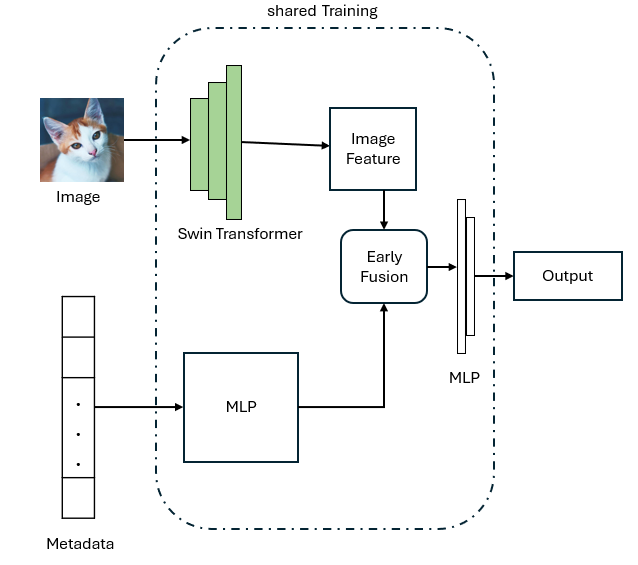

<br>
<br>

###  Architecture 
For Swin (Exp3"Nofusion" vs Exp5"Fusion"), the transformer already attends globally across the image and models relationships between patches and the 12 binary metadata inputs (e.g., subject in focus, human present,) describe similar scene‑level properties, so when they are injected via early fusion, the Swin head can use them as additional context to resolve global patterns and context. 


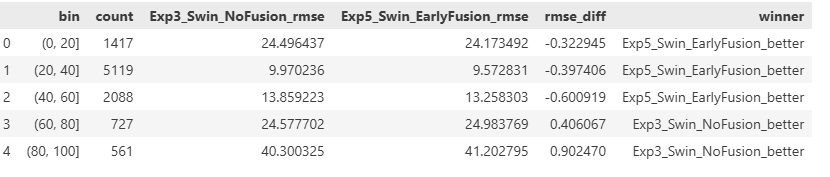

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [93]:
# Cell 1: imports & setup
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageTabDataset
from src.models import EarlyFusionNet



main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp5")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp5"]   # define in config
TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from src.train import run_single_fold

kf = KFold(n_splits=cfg["n_splits"], shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
oof_true = df[TARGET].values
fold_index = np.full(len(df), -1, dtype=int)
fold_rmse = []

start_all = time.time()
for fold, (tr_idx, val_idx) in enumerate(kf.split(df), start=1):
    print(f"\n=== {cfg['name']}: Fold {fold} ===")
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    best_rmse, val_preds, val_targets, val_ids = run_single_fold(
    fold=fold,
    train_df=train_df,
    val_df=val_df,
    img_folder=img_folder,
    cfg=cfg,
    out_dir=out_dir,
    device=device,
    mode="fusion",      #  fusion
    tab_cols=tab_cols,
    workers=16,
    pin_memory=True,
    persistent_workers=True,
    )

    oof_pred[val_idx] = val_preds
    fold_index[val_idx] = fold
    fold_rmse.append(best_rmse)
    print(f"Fold {fold} best RMSE: {best_rmse:.4f}")

all_sec = time.time() - start_all
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")
# final metrics + OOF with fold column
oof_rmse = root_mean_squared_error(oof_true, oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "fold": fold_index,      #  fold for each sample
    "ytrue": oof_true,
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp5_SwinT_384_Strong_TabMLP_Early_MLPHead: Fold 1 ===
Epoch 1/10 | Fold 1 | Train[BCE]: Loss=0.6498 | ValRMSE: 17.8386
Epoch 2/10 | Fold 1 | Train[BCE]: Loss=0.6393 | ValRMSE: 17.5889
Epoch 3/10 | Fold 1 | Train[BCE]: Loss=0.6312 | ValRMSE: 17.6573
Epoch 4/10 | Fold 1 | Train[BCE]: Loss=0.6207 | ValRMSE: 18.4908
Epoch 5/10 | Fold 1 | Train[BCE]: Loss=0.6114 | ValRMSE: 18.0894
Epoch 6/10 | Fold 1 | Train[BCE]: Loss=0.6012 | ValRMSE: 18.9809
Epoch 7/10 | Fold 1 | Train[BCE]: Loss=0.5951 | ValRMSE: 19.1600
Early stopping at epoch 7
Fold 1 best RMSE: 17.5889

=== Exp5_SwinT_384_Strong_TabMLP_Early_MLPHead: Fold 2 ===
Epoch 1/10 | Fold 2 | Train[BCE]: Loss=0.6485 | ValRMSE: 18.0694
Epoch 2/10 | Fold 2 | Train[BCE]: Loss=0.6389 | ValRMSE: 17.7573
Epoch 3/10 | Fold 2 | Train[BCE]: Loss=0.6313 | ValRMSE: 18.0649
Epoch 4/10 | Fold 2 | Train[BCE]: Loss=0.6222 | ValRMSE: 17.9510
Epoch 5/10 | Fold 2 | Train[BCE]: Loss=0.6119 | ValRMSE: 18.2212
Epoch 6/10 | Fold 2 | Train[BCE]: Loss=0.6029 | 

In [4]:
import pandas
df = pd.read_csv(out_dir+"/oof_detail.csv")

for fold in range(1, 6):
    sub = df[df.fold == fold]
    rmse = ((sub.ytrue - sub.oof_pred)**2).mean() ** 0.5
    print(f"Fold {fold} OOF RMSE: {rmse:.4f} (n={len(sub)})")


Fold 1 OOF RMSE: 17.5889 (n=1983)
Fold 2 OOF RMSE: 17.7573 (n=1983)
Fold 3 OOF RMSE: 17.2976 (n=1982)
Fold 4 OOF RMSE: 17.6068 (n=1982)
Fold 5 OOF RMSE: 17.7455 (n=1982)


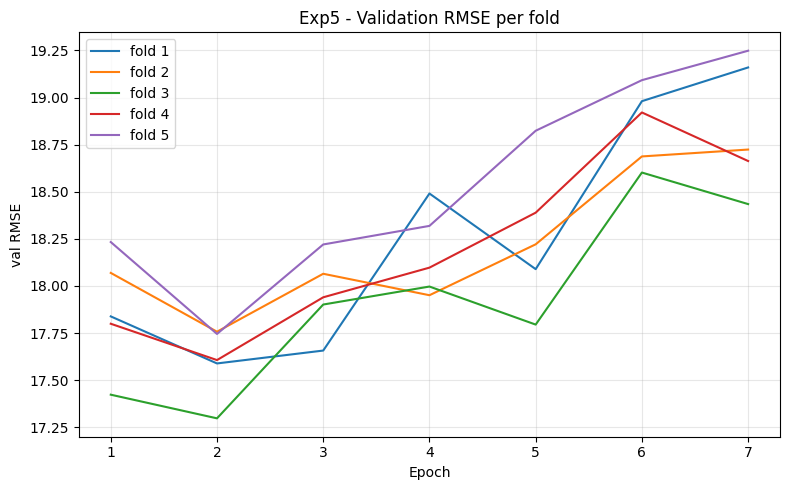

In [6]:
from src.plot import plot_all_folds_history
plot_all_folds_history(out_dir, folds=[1,2,3,4,5], title_prefix="Exp5")

In [7]:
#  Inspect worst error rows

errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()

Id  fold  ytrue   oof_pred    abs_err
0  4c1e05895368c997fdd709bbd1ac3dae     2      2  80.010567  78.010567
1  054cef9194f1a4513dc0965893b589bf     3      2  77.815216  75.815216
2  48a66727373de4e7fa7bb3331cd9acc8     3     96  22.747612  73.252388
3  4435d6f98ad72782ca0cf61f946b016d     5    100  26.892248  73.107752
4  f4dd9ea389798d703ee5ebe2a82c8653     5      2  74.808357  72.808357

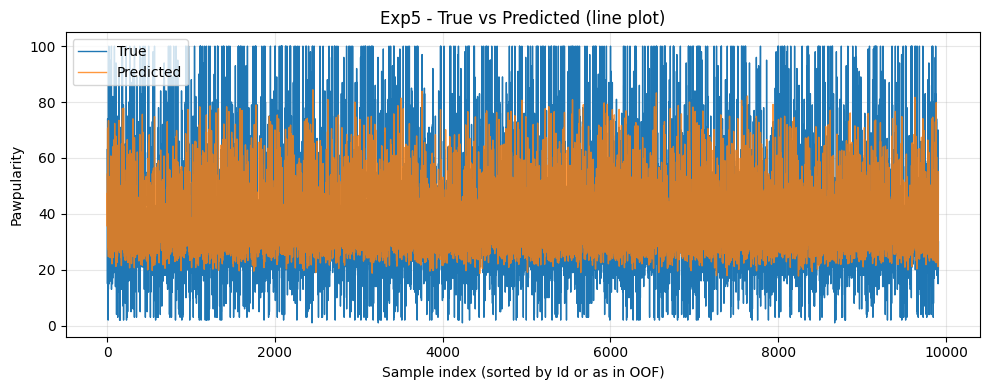

In [6]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp5")





Exp3_Swin_NoFusion OOF RMSE: 17.714745225456582
Exp5_Swin_EarlyFusion OOF RMSE: 17.60001884040648
ΔRMSE (Exp5_Swin_EarlyFusion - Exp3_Swin_NoFusion): -0.11472638505010124


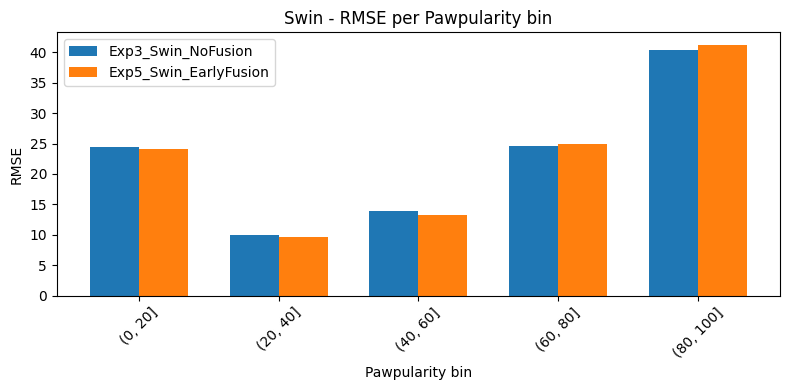

In [2]:
from src.plot import compare_oof_by_bins
bins = [0, 20, 40, 60, 80, 100]

df_bins, rmse3_all, rmse5_all, gap = compare_oof_by_bins(
    oof_path_a="../outputs/exp3/oof_detail.csv",
    oof_path_b="../outputs/exp5/oof_detail.csv",
    bins=bins,
    label_a="Exp3_Swin_NoFusion",
    label_b="Exp5_Swin_EarlyFusion",
    title_prefix="Swin",
)

In [3]:
df_bins.head()

bin  count  Exp3_Swin_NoFusion_rmse  Exp5_Swin_EarlyFusion_rmse  \
0    (0, 20]   1417                24.496437                   24.173492   
1   (20, 40]   5119                 9.970236                    9.572831   
2   (40, 60]   2088                13.859223                   13.258303   
3   (60, 80]    727                24.577702                   24.983769   
4  (80, 100]    561                40.300325                   41.202795   

   rmse_diff                        winner  
0  -0.322945  Exp5_Swin_EarlyFusion_better  
1  -0.397406  Exp5_Swin_EarlyFusion_better  
2  -0.600919  Exp5_Swin_EarlyFusion_better  
3   0.406067     Exp3_Swin_NoFusion_better  
4   0.902470     Exp3_Swin_NoFusion_better

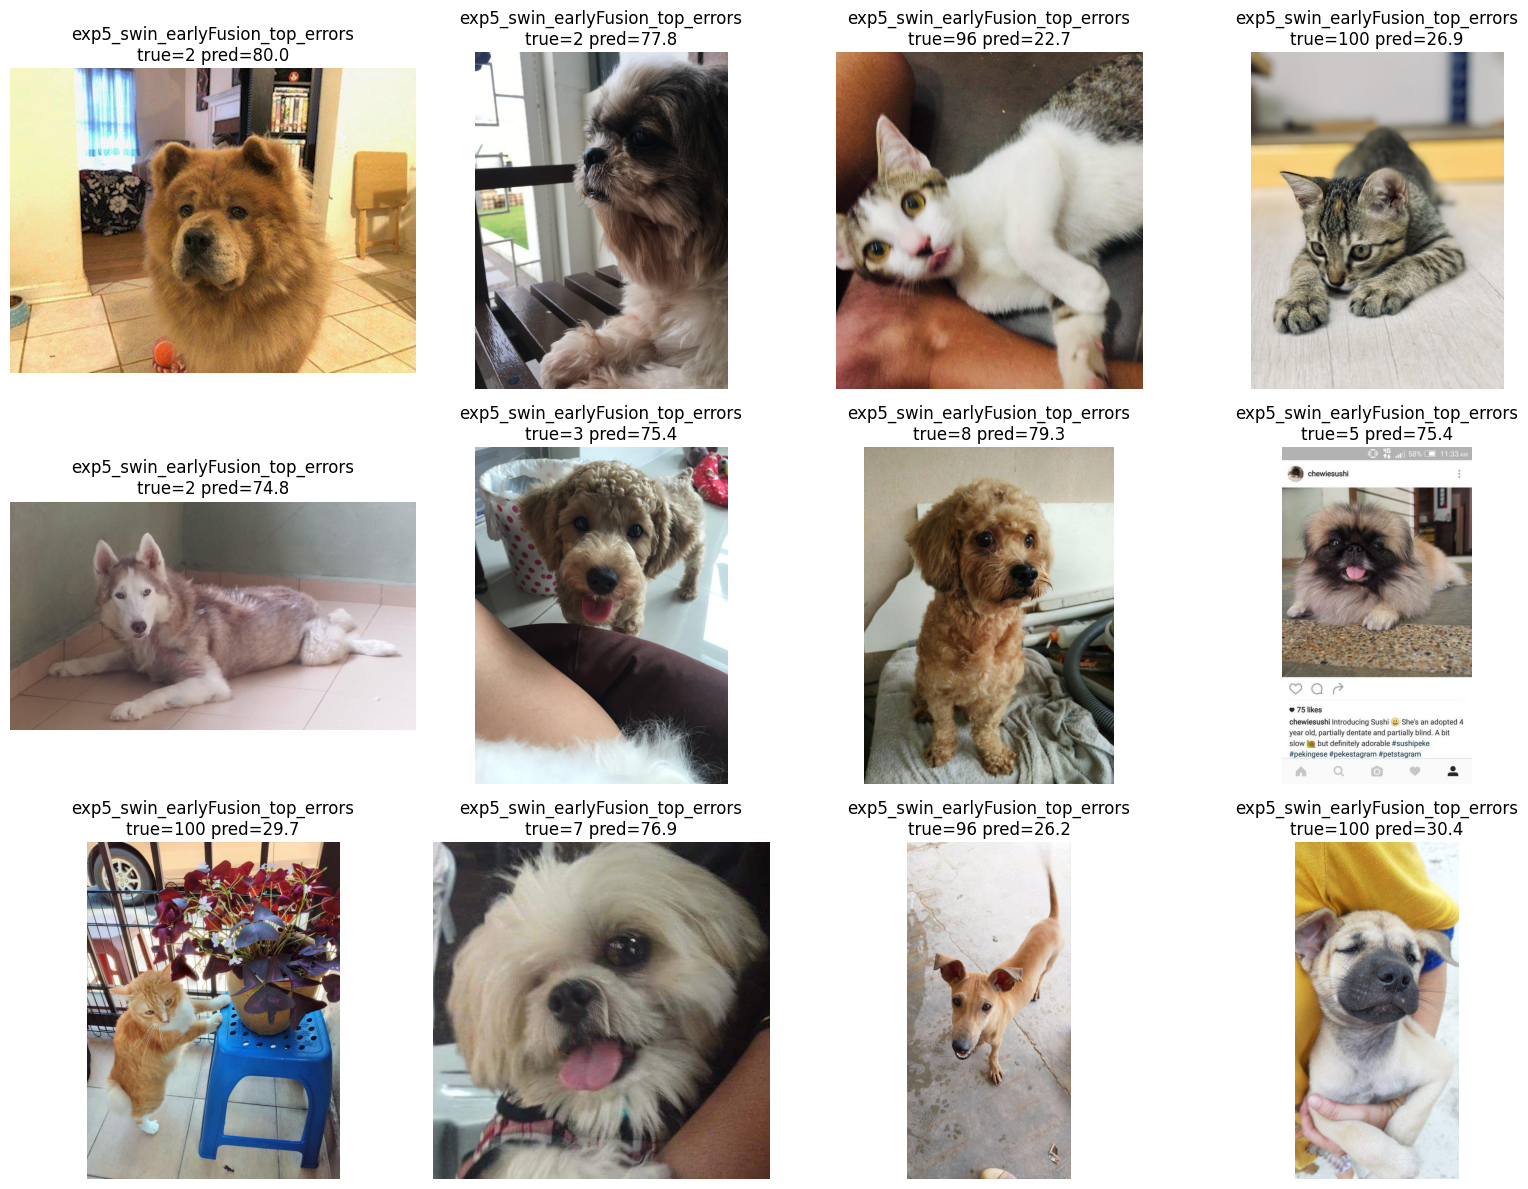

In [7]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_images_grid(err_df, img_folder, n=12, title_prefix="exp5_swin_earlyFusion_top_errors")

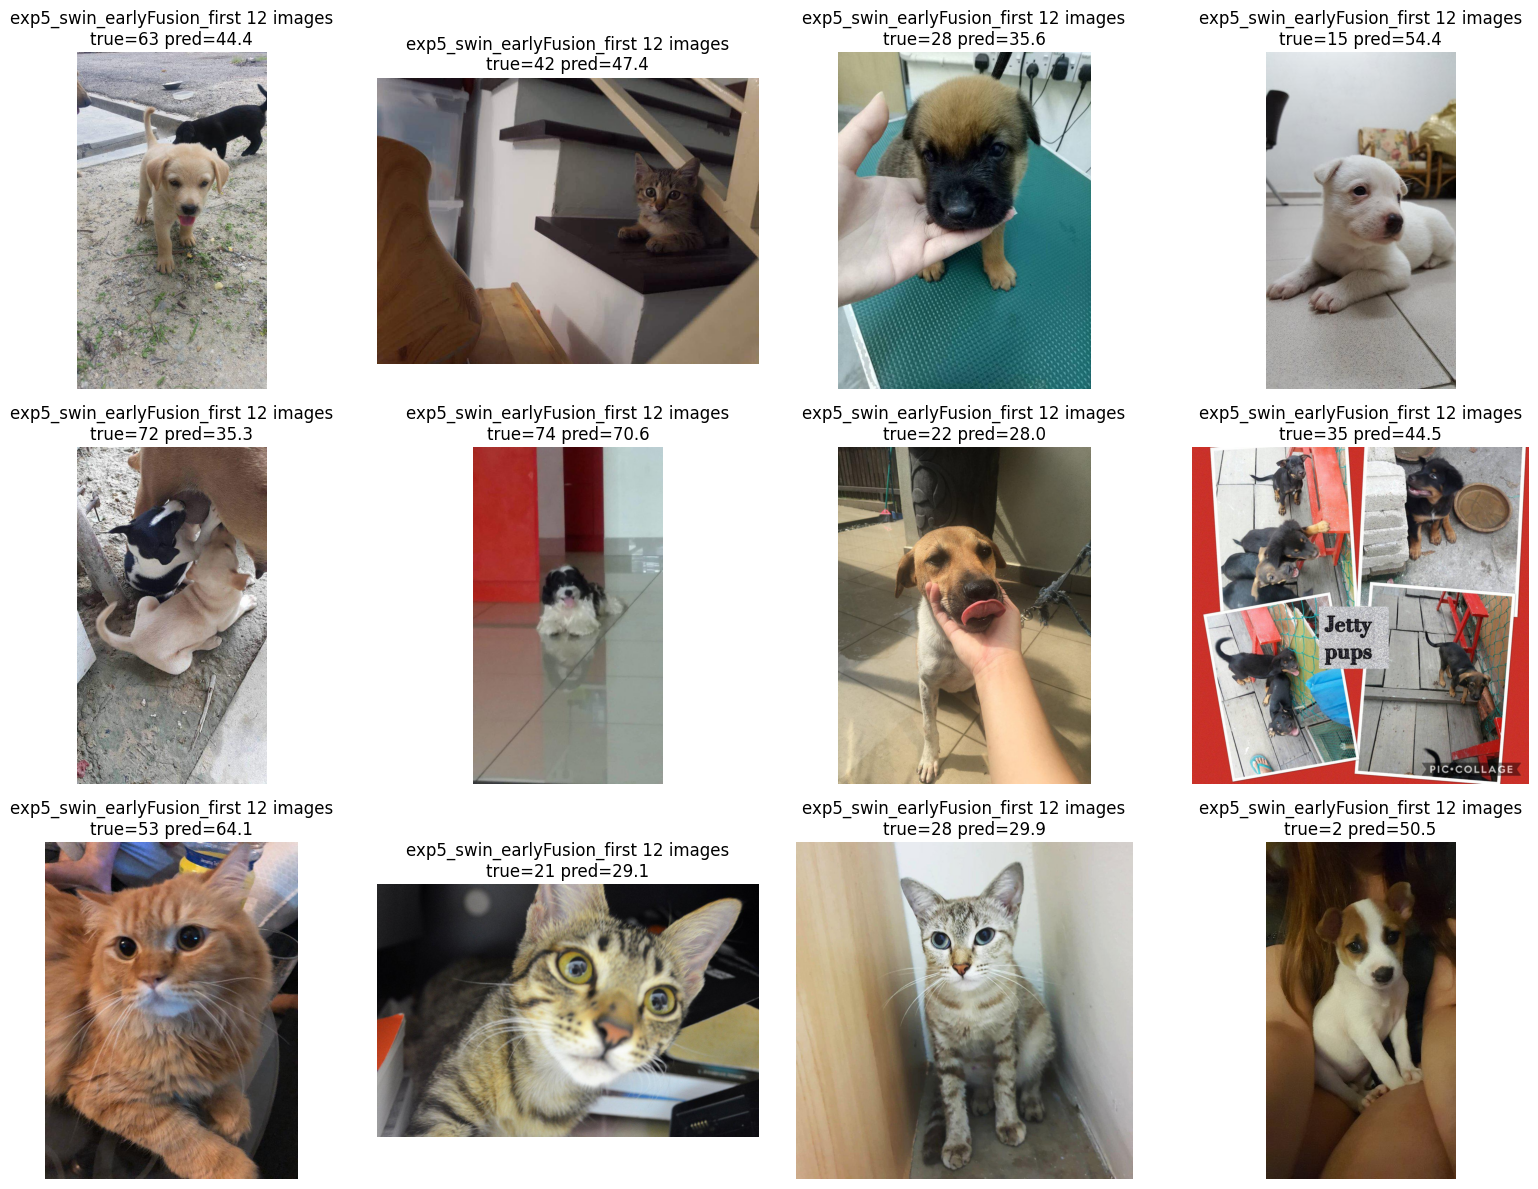

In [8]:

show_images_grid(oof_df, img_folder, n=12, title_prefix="exp5_swin_earlyFusion_first 12 images")